# Imports and Function Definitions

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, KFold, StratifiedKFold

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set()

import warnings
warnings.filterwarnings('ignore')
from polygon import RESTClient

import datetime as dt

In [9]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)
def ensemble_tree_feat_importance(m, df):
    feature_importances = np.mean([
    tree.feature_importances_ for tree in m.estimators_
                                    ], axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)
def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(15,20), legend=False)
def xgb_feat_importance(m, df):
    feature_importances = m.feature_importances_
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)

In [250]:
def model_selection(ml):
    print(ml)
    if ml == 'GB':
        model = GradientBoostingRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-3,1e-5,1e-7]
        grid['n_estimators'] = [10,50,100,1000]
        tscv = TimeSeriesSplit(n_splits=2)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv = tscv)#, n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = GradientBoostingRegressor(learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                                              ).fit(X_train, y_train)

    elif ml == 'RF':
        model = RandomForestRegressor(n_jobs=25)
        grid = dict()
        grid['max_depth'] = [3,5,7,10]
        grid['n_estimators'] = [10,50,100,1000]
        tscv = TimeSeriesSplit(n_splits=2)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv = tscv)#, n_jobs=25), n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = RandomForestRegressor(
                    max_depth=grid_result.best_params_['max_depth'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                        ).fit(X_train, y_train)
    
    
    print(model_best)
    y_pred = model_best.predict(X_test)
    print('MAE: ', mean_absolute_error(y_pred, y_test), '\nMSE: ', mean_squared_error(y_pred,y_test), '\nRMSE: ', np.sqrt(mean_squared_error(y_pred,y_test)))

    return(model_best, y_pred)#, [X_train, X_test, y_train, y_test])

# Cleaning and Merging

In [365]:
client = RESTClient(api_key="18U85gkK04AWHrbE3oWvG9b3fF8JdlxQ")

In [547]:
vxx = client.get_aggs(ticker='VXX', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)
spy = client.get_aggs(ticker='SPY', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)
uso = client.get_aggs(ticker='USO', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)

In [548]:
poly_dict = {'vxx':vxx, 'spy':spy, 'uso':uso}

In [549]:
for data in poly_dict.keys():
    poly_dict[data] = pd.DataFrame(poly_dict[data])[['close', 'timestamp']]
    poly_dict[data] = poly_dict[data].rename(columns={'close':'Close', 'timestamp':'Local time'})
    poly_dict[data]['Local time'] = pd.to_datetime(poly_dict[data]['Local time'], unit='ms')

In [550]:
vxx = poly_dict['vxx']
spy = poly_dict['spy']
uso = poly_dict['uso']

In [551]:
fut = pd.read_csv('C:\\Users\\nfischer\\Downloads\\LIGHT.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
gas = pd.read_csv('C:\\Users\\nfischer\\Downloads\\GAS.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
btc = pd.read_csv('C:\\Users\\nfischer\\Downloads\\BTCUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
bond = pd.read_csv('C:\\Users\\nfischer\\Downloads\\USTBOND.TRUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')

In [676]:
data_dict = {'fut':fut, 'gas':gas, 'vxx':vxx, 'spy':spy, #'uso':uso, 
            'btc':btc, 'bond':bond}

## Datetime and indexing

In [475]:
idx = pd.to_datetime(data_dict['fut']['Local time'])
idx=idx.apply(lambda x: x.replace(tzinfo=None))

In [677]:
for data in data_dict.keys():
    if not data in ['vxx', 'spy', 'uso']:
        data_dict[data] = data_dict[data].set_index(idx)
        data_dict[data] = data_dict[data].drop(['Open', 'High', 'Low', 'Volume', 'Local time'], axis=1)
    else:
        data_dict[data] = data_dict[data].set_index('Local time')

## Merging

In [678]:
df = pd.DataFrame(index=data_dict['vxx'].index)
for data in data_dict.keys():
    df = pd.merge(df, data_dict[data], left_index=True, right_index=True, suffixes=['', '_'+data], how='left')
df = df.rename(columns={'Close':'Close_fut'})

Cut to market hours

In [679]:
df['date'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').date(), axis=1)
df['time'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').time(), axis=1)

In [683]:
df = df.loc[ (df['time']>dt.time(9)) & (df['time']<dt.time(16)) ]

In [684]:
df

,Close_fut,Close_gas,Close_vxx,Close_spy,Close_btc,Close_bond,date,time
Local time,,,,,,,,
2022-04-01 11:00:00,77.236,3.8018,25.46,454.21,46736,156.492,2022-04-01,11:00:00
2022-04-01 11:05:00,77.122,3.8148,25.43,454.23,46673,156.555,2022-04-01,11:05:00
2022-04-01 11:35:00,77.172,3.7668,25.38,454.00,46848,156.522,2022-04-01,11:35:00
2022-04-01 11:55:00,77.132,3.7638,25.37,454.12,46489,156.583,2022-04-01,11:55:00
2022-04-01 12:00:00,76.972,3.7419,25.38,454.00,46522,156.676,2022-04-01,12:00:00
...,...,...,...,...,...,...,...,...
2022-09-01 15:35:00,78.917,3.9290,19.76,NaN,42315,155.207,2022-09-01,15:35:00
2022-09-01 15:40:00,78.917,3.9290,19.82,NaN,42278,155.207,2022-09-01,15:40:00
2022-09-01 15:45:00,78.917,3.9290,19.76,NaN,42276,155.207,2022-09-01,15:45:00


The plot below shows the high daily variance and the gaps between data are non-trading hours

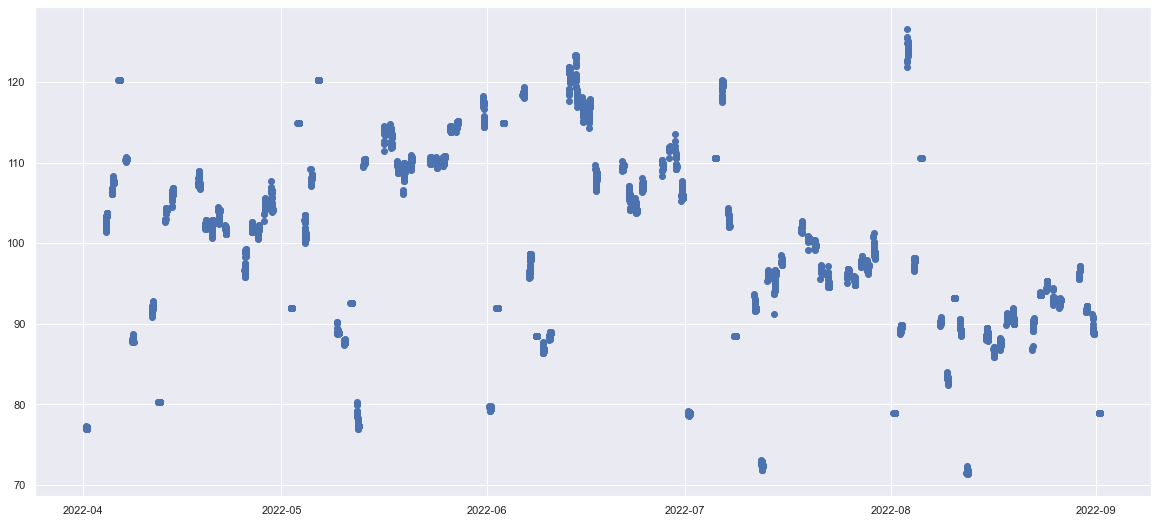

In [685]:
plt.subplots(figsize=(20,9))
plt.scatter(df.index, df['Close_fut'])

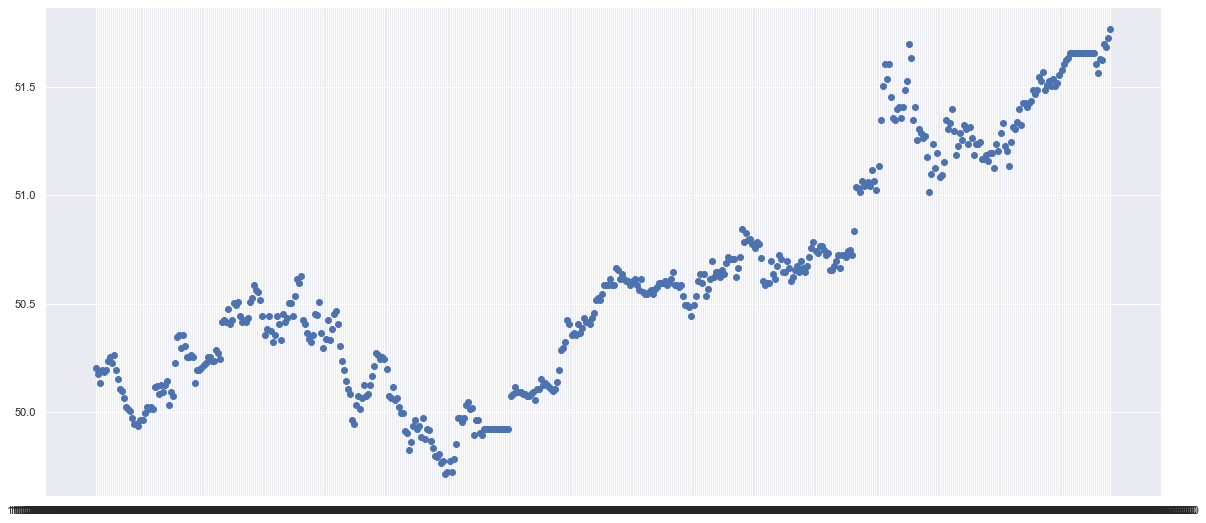

In [674]:
plt.subplots(figsize=(20,9))
plt.scatter(fut['Local time'][:500], fut['Close'][:500])

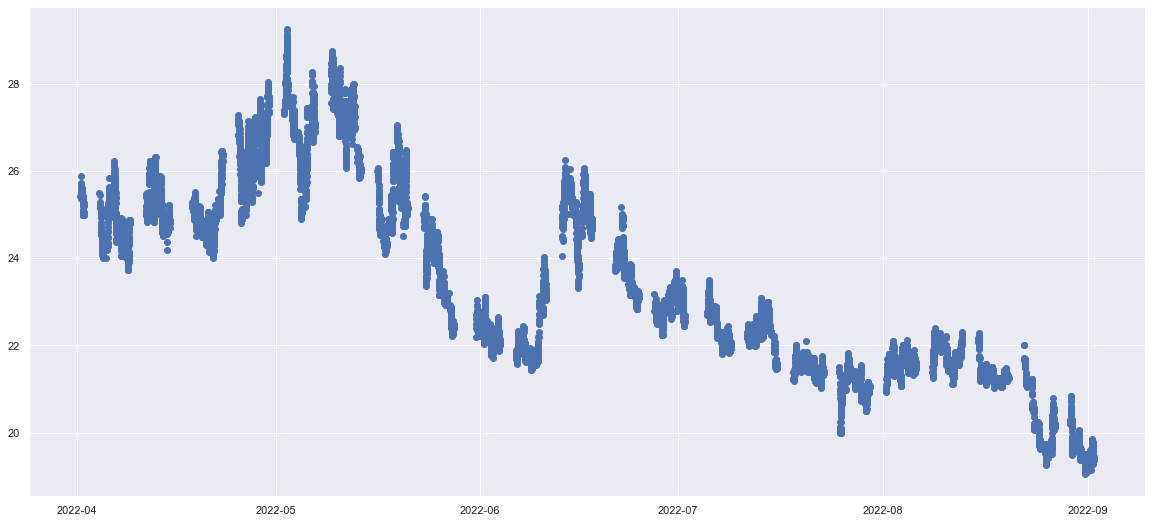

In [681]:
plt.subplots(figsize=(20,9))
plt.scatter(vxx['Local time'], vxx['Close'])

## Create log returns

Calculate log returns for each feature.

In [643]:
for feat in set(df.columns) - {'date', 'time'}:
    df[feat] = np.log( df[feat] / df[feat].shift(1) )

Lots of nulls.  Fix later

In [644]:
df.loc[df['Close_spy'].isna()]

,Close_fut,Close_gas,Close_vxx,Close_spy,Close_btc,Close_bond,date,time
Local time,,,,,,,,
2022-04-01 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-01,11:00:00
2022-05-20 09:50:00,0.006661,0.004291,-0.047253,NaN,-0.026998,0.003340,2022-05-20,09:50:00
2022-05-20 11:00:00,-0.004557,-0.004922,0.002819,NaN,-0.014330,0.001316,2022-05-20,11:00:00
2022-06-27 09:35:00,0.011650,0.016535,0.000437,NaN,-0.023240,-0.004379,2022-06-27,09:35:00
2022-06-27 11:05:00,0.005898,0.022409,0.002618,NaN,0.001308,-0.000007,2022-06-27,11:05:00
...,...,...,...,...,...,...,...,...
2022-09-01 15:35:00,0.000000,0.000000,-0.000511,NaN,-0.000685,0.000000,2022-09-01,15:35:00
2022-09-01 15:40:00,0.000000,0.000000,0.003032,NaN,-0.000875,0.000000,2022-09-01,15:40:00
2022-09-01 15:45:00,0.000000,0.000000,-0.003032,NaN,-0.000047,0.000000,2022-09-01,15:45:00


Fill nulls with spline interpolation.  

In [645]:
df = df.interpolate(method='spline', order=3)

In [646]:
df

,Close_fut,Close_gas,Close_vxx,Close_spy,Close_btc,Close_bond,date,time
Local time,,,,,,,,
2022-04-01 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-01,11:00:00
2022-04-01 11:05:00,-0.001477,0.003414,-0.001179,0.000044,-0.001349,0.000402,2022-04-01,11:05:00
2022-04-01 11:35:00,0.000648,-0.012662,-0.001968,-0.000506,0.003742,-0.000211,2022-04-01,11:35:00
2022-04-01 11:55:00,-0.000518,-0.000797,-0.000394,0.000264,-0.007693,0.000390,2022-04-01,11:55:00
2022-04-01 12:00:00,-0.002077,-0.005836,0.000394,-0.000264,0.000710,0.000594,2022-04-01,12:00:00
...,...,...,...,...,...,...,...,...
2022-09-01 15:35:00,0.000000,0.000000,-0.000511,0.002426,-0.000685,0.000000,2022-09-01,15:35:00
2022-09-01 15:40:00,0.000000,0.000000,0.003032,0.002426,-0.000875,0.000000,2022-09-01,15:40:00
2022-09-01 15:45:00,0.000000,0.000000,-0.003032,0.002426,-0.000047,0.000000,2022-09-01,15:45:00


## Process each day separately

Doing this shows that some dates have missing data for the Polygon data.  This sucks

In [647]:
days = list(set([d.date() for d in df.index]))

Now we split the data into individual days.  We calculate the $n$ period rolling standard deviation as our outcome measure within each day.  Then, we can concat the data together

In [648]:
n=12
day_dict = {}
for day in days:
    day_dict[day] = df.loc[df['date'] == day]
    del day_dict[day]['date']
    
    day_dict[day][str(n)+'_oil_std'] = day_dict[day].rolling(n)['Close_fut'].std()
    day_dict[day] = day_dict[day][n:]

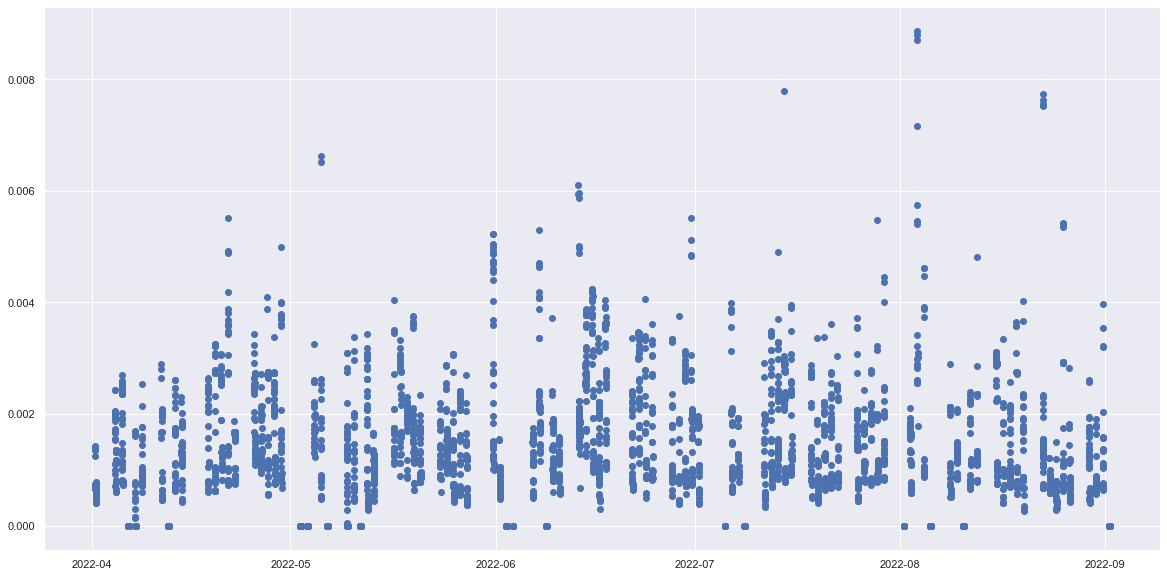

In [659]:
concat = pd.concat(day_dict.values())[str(n)+'_oil_std']
plt.subplots(figsize=(20,10))
plt.scatter(concat.index, concat)

# Test Train Splits

We will train on a rolling $k$ length period and predict the next bar of vol.

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Initial Model testing

In [251]:
res = {'RF':None, 'GB':None}
for model in res.keys():
    r = model_selection(model)
    res[model] = r

RF
RandomForestRegressor(max_depth=3, n_estimators=10)
MAE:  0.0001873201182509463 
MSE:  3.739762390653617e-08 
RMSE:  0.00019338465271715894
GB
GradientBoostingRegressor(learning_rate=1e-07, n_estimators=10)
MAE:  0.00020812947123731586 
MSE:  4.332753712585249e-08 
RMSE:  0.00020815267744098918


In [244]:
day[77:]

,Close_fut,Close_gas,Close_btc,Close_bond,fut_78_std
Local time,,,,,
2021-09-08 14:25:00+05:00,0.000374,-0.000469,-0.000216,0.000397,0.002224
2021-09-08 14:30:00+05:00,-0.000075,-0.000592,-0.002829,-0.000385,0.002045
2021-09-08 14:35:00+05:00,0.000749,0.000049,-0.000043,0.000000,0.002023
2021-09-08 14:40:00+05:00,-0.001182,-0.003926,-0.000628,0.000000,0.001964
2021-09-08 14:45:00+05:00,0.000135,-0.000223,0.000433,-0.000214,0.001961
2021-09-08 14:50:00+05:00,0.000599,-0.000471,-0.007409,0.000006,0.001950
2021-09-08 14:55:00+05:00,-0.000898,0.000198,0.002772,-0.000568,0.001943
2021-09-08 15:00:00+05:00,0.000225,0.000273,0.003286,-0.000177,0.001827
2021-09-08 15:05:00+05:00,0.000509,-0.000050,0.002386,-0.000208,0.001791


In [252]:
res

{'RF': (RandomForestRegressor(max_depth=3, n_estimators=10),
  array([0.00191586, 0.00188938, 0.00184308, 0.00178188])),
 'GB': (GradientBoostingRegressor(learning_rate=1e-07, n_estimators=10),
  array([0.00187836, 0.00187836, 0.00187836, 0.00187836]))}